In [1]:
# Compares the performance
%matplotlib inline

import numpy as np
import nengo
import nengo_benchmarks
import nengo_normal_form
import nengo_gui.ipython
import matplotlib.pyplot as plt
import nengo.utils.numpy as npext
from SurrogateModel_ver2 import SurrogateModel 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Variables initialization
tau_syn = 0.001
sim_time = 10
dt = 0.001
rad = 30
dim = 1
ARMA_orders = [2, 0, 2]
trange= np.linspace(0, sim_time, num=sim_time/dt)

seed = None

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  


In [3]:
# Declare the input vector 
input_vec = (lambda t: t)
# input_vec = (lambda t: t*0+1)
# input_vec = (lambda t: np.cos(t))
# input_vec = (lambda t: t**2)
# input_vec = (lambda t: np.log(t))

In [4]:
# Initial model & connections from Nengo side
model = nengo_benchmarks.CommunicationChannel().make_model(D=dim, L=1, T=sim_time)
# model = nengo_benchmarks.CircularConvolution().make_model(D=dim)
# model, p = nengo_normal_form.convert(model, single_decoder=False)
# nengo_gui.ipython.IPythonViz(model)

# Minor edits to the model for convenience
with model:
    ensembles = model.ensembles
    probes = model.probes
    connections = model.connections
    pop = ensembles[-1]
    end = nengo.Node(None, size_in=dim, label='end') # For decoders
    conn_end = nengo.Connection(pop, end)
    for ens in ensembles:
        ens.radius = rad
    
    input_node = model.nodes[0]
    input_node.output = input_vec


In [5]:
# Pass in the model to the SurrogateModel API; initialize default parameters on the API side
surr_model = SurrogateModel(model, dim) # input of: ramp, const, cos, squared, log

# Simulate by model.run
surr_model.run(dt, sim_time)
surr_model.estimateSurrModel(ARMA_orders, tau_syn)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:03.                                                 
[[ 0.          0.          0.1688289  ..., -0.00153577  0.43838079
  -0.08430485]]


surr_model.RMSE: 0.469415679199


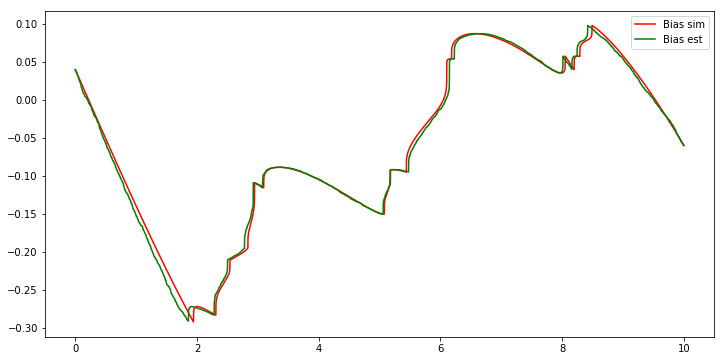

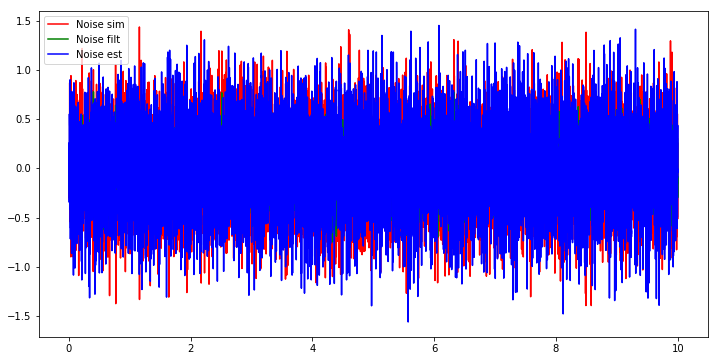

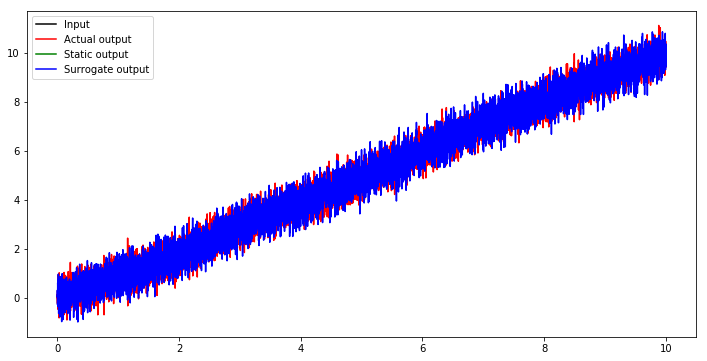

In [6]:
# Plot the surrogate model estimation
trange = surr_model.trange

plt.figure(figsize=(12,6))
plt.plot(trange, surr_model.bias_values_sim.T, 'r', label = "Bias sim")
plt.plot(trange, surr_model.bias_values_est.T, 'g', label= "Bias est")
plt.legend()

plt.figure(figsize=(12,6))
plt.plot(trange, surr_model.noise_values_sim.T, 'r', label ="Noise sim")
plt.plot(trange, surr_model.noise_values_filt.T, 'g', label="Noise filt")
plt.plot(trange, surr_model.noise_values_est.T, 'b', label="Noise est")
plt.legend()

plt.figure(figsize=(12,6))
plt.plot(trange, surr_model.input.T, 'k', label='Input')
plt.plot(trange, surr_model.output.T, 'r', label = 'Actual output')
plt.plot(trange, surr_model.static_output.T, 'g', label = 'Static output' )
plt.plot(trange, surr_model.surr_output.T, 'b', label="Surrogate output")
plt.legend()

print "surr_model.RMSE: {}".format(surr_model.RMSE)